# 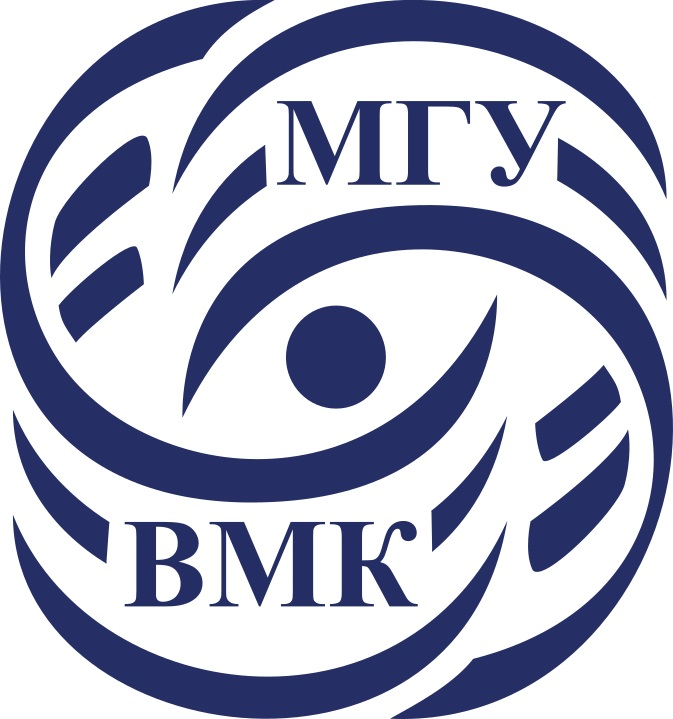

# Машинное обучение. ВМК МГУ

# Практическое задание 8: Градиентный бустинг деревьев

## Важно! О формате сдачи

* Практически все выделенные задания из ноутбука оцениваются по системе <font color='red'>кросс-рецензирования.</font> Задания, в которых надо реализовать свой код и послать в систему, выделены здесь и в PDF отдельно.
* В этом задании также есть задания по типу <font color='red'>ML-решения.</font>
* При решении ноутбука <font color='red'>используйте данный шаблон.</font> Не нужно удалять текстовые ячейки с разметкой частей ноутбука и формулировками заданий. Добавлять свои ячейки, при необходимости, конечно, можно.
* Везде, где в формулировке задания есть <font color='red'>какой-либо вопрос (или просьба вывода),</font> необходимо прописать ответ в ячейку (код или Markdown).
* Наличие <font color='red'>кода решения обязательно.</font> Письменные ответы на вопросы без сопутствующего кода оцениваются в 0 баллов.
* Если в ячейке написана фраза <font color='red'>"Вывод"/"Ответ на вопрос" и.т.д.,</font> то ожидается ответ в виде текста (можете добавить ячейки с кодом, если считаете это необходимым, но это необязательно). Если в ячейке написано <font color='red'>"Your code here" и пр. </font>, то ожидается ответ в виде кода (можете добавить ячейки с кодом, если считаете это необходимым, но это необязательно). Если есть и ячейка с фразой "Вывод", и ячейка с фразой "Your code here", то в ответе ожидается и код, и текст

__В этом задании вы..:__

- Познакомитесь с несколькими новыми библиотеками машинного обучения
- Сравните между собой разные реализации градиентных бустингов
- Примените все полученные знания для получения лучшего скора на датасете фильмов


<font color=orange><h3>*Примерное время выполнения (execution time/время выполнения, если нажать run all) всех ячеек ноутбука (без ML-решения): 60 минут*</font></h3>

----------------------------------------------
<font color="white" style="opacity:0.2023"></font>

Немного магии, которую не надо менять, но надо выполнить перед каждым запуском!

## Подготовка рабочей среды
Сначала установим нужные нам версии библиотек. Мы гарантируем, что в данных версиях задание будет корректно отрабатывать.

После установки нужных версий, **возможно,** нужно перезагрузить среду (runtime), но скорее всего вам это не понадобится


На скачивание файла и установку понадобится не более 5 минут.

**Важно!**
Устанавливать нужные версии нужно каждый раз, когда создается новый рантайм. Например, если вы 2 часа подряд делаете это задание, то подготовить библиотеки достаточно 1 раз. Но если вы, например, начали в понедельник, затем закрыли/выключили ноутбук, то при продолжении в среду, вам нужно будет запустить рантайм заново и следовательно заново установить библиотеки.

**Важно!**
Если вы предпочитаете делать практические задания на своем личном ноутбуке, то проверьте, что вы установили рабочее окружение в [соответствии с гайдом](https://github.com/MSU-ML-COURSE/ML-COURSE-23-24/blob/main/tutorials/Туториал%20по%20установке%20рабочего%20окружения%20в%20Python%20для%20решения%20задач.pdf)

<font color='red'>**Важно!**</font> В файлике requirements_small.txt поменялась версия `gdown` _(в предыдущей версии, к сожалению, стали появляться ошибки при скачивании через эту утилиту)_! Если вы работаете в Google Colab, то ничего дополнительно делать не нужно, если вы работаете локально, то рекомендуем обновить версию `gdown` в виртуальном окружении на `>=4.7.3`. Более подробные инструкции вы найдете в треде по этому заданию в чате курса.

In [1]:
!pip install --upgrade gdown
!gdown 1pIw8GdGKY6fZ_XNPc6snimdV6lbXJ199
!pip install -r /content/requirements_small.txt

Downloading...
From: https://drive.google.com/uc?id=1pIw8GdGKY6fZ_XNPc6snimdV6lbXJ199
To: /content/requirements_small.txt
100% 374/374 [00:00<00:00, 963kB/s]


In [2]:
import catboost
assert(catboost.__version__ == '1.2.1')




# Введение

Привет, ребятушки!

Сегодня мы с вами будем решать очень важную задачу, а именно оценивать цену подержанных автомобилей в ряде стран. Делать мы это будем с помощью различных методов градиентного бустинга. Мы с вами узнаем, что в мире существует не только sklearn, и что существуют библиотеки, облегчающие нам задачу поиска оптимальных параметров для моделей.

**<font color='red'>Внимание!</font> Во всех заданиях в качестве целевой метрики используется MAE (средняя абсолютная ошибка).** Значение MAE вычисляется как

$$
  MAE = \sum_{i = 1}^N\dfrac{|a(x_i) - y_i|}{N},
$$

где $N$ - число объектов в тестовой выборке, $x_i$ - вектор признаков i-го объекта, $a(x_i)$ - предсказание на i-ом объекте, $y_i$ - значение целевого признака на i-м объекте.

## Используемые библиотеки

В этом задании нам понадобятся три библиотеки, которыми вы ранее не пользовались в этом курсе, а именно:

**XGBoost**: Документация [здесь](https://xgboost.readthedocs.io/en/stable/).<br />
**LightGBM**: Документация [здесь](https://lightgbm.readthedocs.io/en/latest/index.html). Также дополнительно про установку [тут](https://pypi.org/project/lightgbm/).<br />
**Catboost**: Документация [здесь](https://catboost.ai/en/docs/). Можно найти также некоторую информацию на русском [тут](https://habr.com/ru/company/otus/blog/527554/).<br />
**HyperOpt**: Документация [здесь](http://hyperopt.github.io/hyperopt/). <br />

<font color='red'>**Внимание!**</font> Вникать и подробно читать документацию к каждой библиотеке нет необходимости! Достаточно обращаться туда для нахождения примеров обучения.


----------------------------------------------
<font color="white" style="opacity:0.2023"></font>

## Различия в методах бустинга

Каждая библиотека, которую мы будем сегодня использовать, имеет  свой подход к обучению. Понимание этих различий выходит за рамки данного задания, но при желании можно обратиться к документации библиотек или [лекциям Дьяконова](https://github.com/Dyakonov/MSUML/blob/main/2021autumn/PZAD053_gradboosting_202106n___.pdf).

## Как правильно перебирать параметры

В этом ноутбуке мы будем несколько раз заниматься поиском оптимальных параметров для градиентного бустинга, перебирая задания по заданной сетке. В этом задании от вас не будет требоваться найти самые лучшие параметры, но всё равно важно правильно составлять сетку для перебора. Для этого нужно понимать суть параметров и их смысл.



<font color='green'>**learning_rate**</font> -- **темп обучения** нашего метода. Для этого метода сетка перебора должна быть логарифмической, т.е. перебирать порядковые значения (к примеру, `[1e-3, 1e-2, 1e-1, 1]`). В большинстве случаев достаточно перебрать значения от `1e-5 до 1`.<br />

<font color='green'>**max_depth**</font> -- **максимальная глубина деревьев** в ансамбле. Вообще говоря, эта величина зависит от числа признаков, но обычно лучше растить небольшие деревья. К примеру, библиотека `CatBoost`, которую мы будем исследовать сегодня, рекомендует перебирать значения до `10` (и уточняется, что обычно оптимальная глубина лежит `от 6 до 10`).<br />

<font color='green'>**subsample**</font> -- **объем выборки**, использующийся для обучения отдельного дерева, лежит в интервале `(0, 1]`. Перебирать стоит хотя бы с шагом `0.25` <br />

<font color='green'>**n_estimators**</font> -- **количество деревьев** в ансамбле. Обычно стоит перебирать с каким-то `крупным шагом` (можно по логарифмической сетке). Здесь важно найти баланс между производительностью, временем обучения и качеством. Обычно `нескольких тысяч` деревьев бывает достаточно.<br />

<font color='red'>**NB!**</font> Учтите, что в реальных задачах необходимо следить за тем, что оптимальные значения параметров не попадают на границы интервалов, т.е. что вы нашли хотя бы локальный минимум. Если вы перебрали значения параметра от 1 до 10 и оказалось, что 10 - оптимальное значение, значит следует перебрать и бОльшие числа, чтобы убедиться, что качество не улучшается дальше (или по крайней мере убедиться, что рост качества сильно замедляется и на сильное улучшение рассчитывать не стоит.


## Подготовка датасета

Все библиотеки, используемые сегодня, мы будем проверять на одних и тех же параметрах:

    n_estimators=1000, max_depth=5, learning_rate=0.1
    
Таким образом мы устанавливаем, соответственно, число деревьев в ансамбле равным 1000, ограничиваем максимальную глубину деревьев 5 и устанавливаем темп обучения равным 0.1. Создадим сразу словарь, чтобы передавать эти параметры создаваемым регрессорам (если вдруг не знали, словарь можно передавать как параметры, поставив перед ним **).

Эти параметры мы вынесем в отдельную переменную `test_parameters`.

При желании можно почитать про этот датасет на платформе kaggle: [ссылка на данные](https://www.kaggle.com/bushnag/cars-in-the-middle-east?select=dataframe_YesIndex_YesHeader_C.csv). <span style="color:red"> <font color="red">Не скачивайте датасет из kaggle для выполнения ноутбука, поскольку его могут изменить.</font></span> Нас интересует файл dataframe_YesIndex_YesHeader_C.csv, поскольку он уже хорошо предобработан (хотя, конечно, датасаентисты должны сами уметь это делать, но ладно).
Давайте попробуем загрузить датасет в память и посмотреть, как он выглядит.

При работе в google colab для скачивания датасета достаточно запустить следующую ячейку.

При работе с ноутбуком <span style="color:red"> <font color="red">на локальном компьютере</font></span> Вы можете скачать файл по [этой ссылке](https://drive.google.com/file/d/1gdDv2kTCEkF3ia1vvbvRFJM0YfqmPplb/view?usp=sharing) и чуть ниже заменить ` /content/dataframe_YesIndex_YesHeader_C.csv` (в строке с `read_csv`) на ваш локальный путь до файла.

In [3]:
# при локальном выполнении запускать эту ячейку НЕ НАДО
!gdown 1gdDv2kTCEkF3ia1vvbvRFJM0YfqmPplb

Downloading...
From: https://drive.google.com/uc?id=1gdDv2kTCEkF3ia1vvbvRFJM0YfqmPplb
To: /content/dataframe_YesIndex_YesHeader_C.csv
100% 568k/568k [00:00<00:00, 33.7MB/s]


In [4]:
%matplotlib inline
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import mean_absolute_error, make_scorer

from hyperopt import hp, tpe, Trials
from hyperopt.fmin import fmin
from hyperopt.pyll import scope

from xgboost import XGBRegressor

from lightgbm import LGBMRegressor

from catboost import CatBoostRegressor

import matplotlib.pyplot as plt

import pandas as pd

import numpy as np

import time

In [5]:
test_parameters = {"n_estimators": 1000, "max_depth": 5, "learning_rate": 0.1, "subsample": 1.0}

df = pd.read_csv('/content/dataframe_YesIndex_YesHeader_C.csv', index_col=0)
df.head()

,Engine Capacity,Cylinders,Drive Type,Fuel Tank Capacity,Fuel Economy,Fuel Type,Horsepower,Torque,Transmission,Top Speed,...,Acceleration,Length,Width,Height,Wheelbase,Trunk Capacity,name,price,currency,Country
0,1.2,3,0,42.0,4.9,0,76,100.0,0,170,...,14.0,4.245,1.670,1.515,2.550,450.0,Mitsubishi Attrage 2021 1.2 GLX (Base),34099.0,0,0
1,1.2,3,0,42.0,4.9,0,76,100.0,0,170,...,14.0,4.245,1.670,1.515,2.550,450.0,Mitsubishi Attrage 2021 1.2 GLX (Base),34099.0,0,0
2,1.4,4,0,45.0,6.3,0,75,118.0,1,156,...,16.0,3.864,1.716,1.721,2.513,2800.0,Fiat Fiorino 2021 1.4L Standard,41250.0,0,0
3,1.6,4,0,50.0,6.4,0,102,145.0,0,180,...,11.0,4.354,1.994,1.529,2.635,510.0,Renault Symbol 2021 1.6L PE,44930.0,0,0
4,1.5,4,0,48.0,5.8,0,112,150.0,0,170,...,10.9,4.314,1.809,1.624,2.585,448.0,MG ZS 2021 1.5L STD,57787.0,0,0


## <font color='orange'>**Задание 0 (без проверки, 0 баллов)**</font>

Посмотрите на цены автомобилей. Попробуйте понять, написаны они в одной валюте или нет. Если нет -- будут ли у нас серьезные проблемы при использовании деревьев? Стоит ли нам что-то сделать для того, чтобы нивелировать эту проблему?


In [ ]:
df['price'].unique()

array([  34099.,   41250.,   44930., ..., 1950000., 1850000., 9600000.])

In [ ]:
df['price'].value_counts()

12000.0      30
15500.0      27
19000.0      25
8000.0       23
18000.0      23
             ..
179800.0      1
117000.0      1
144800.0      1
108800.0      1
9600000.0     1
Name: price, Length: 2011, dtype: int64

In [ ]:
min = df['price'].min()
max = df['price'].max()

print(f'Min price = {min}\nMax price = {max}')

Min price = 2899.0
Max price = 10780000.0


**<font color='magenta'>Выводы:</font>** Скорее всего цены автомобилей представлены в разных валютах, т.к они лежат в диапазоне от 2899 до 10780000 денежных единиц.  

В глаза бросаются две проблемы: у нас имеется информация о производителе автомобиля, скрытая в текстовой переменной модели автомобиля (нет отдельного признака). Также имеются некоторые категориальные переменные. Со всем этим безобразием надо что-то сделать.



## <font color='orange'>**Задание 1 (кросс-проверка, 2 балла)**</font>
**Данные**: датасет со стоимостью подержанных автомобилей  
**Цели**: В данном задании следует выполнить следующие пункты (выполнять можно в любом порядке)
1. Изучить датасет, проверить наличие `пропусков.` Под пропусками подразумевается значение N/A вместо признака. При необходимости заменить их на среднее значение признака.
3. Добавить `столбец brand` с информацией о производителе автомобиля (для простоты можно взять первое слово в названии модели).
4. Решить, какие признаки Вы считаете `категориальными.`
5. Создать `датасет А`, в котором выбранные категориальные признаки установлены как категориальные. Для этого необходимо создать вектор целевых значений Y (столбец цен автомобилей) и матрицу признаков X, в которой все категориальные переменные помечены как .astype('category'). Дополнительно стоит создать список с названиями и индексами столбцов категориальных переменных (поможет в будущем).
6. Создать `датасет B` без категориальных признаков. Для этого необходимо просто удалить из матрицы признаков все категориальные переменные.
7. Создать `датасет C`, в котором выбранные категориальные признаки закодированы через one-hot encoding. Для этого необходимо из матрицы признаков удалить выбранные категориальные переменные, а затем добавить новые признаки, соответствующие one-hot encoding этих категориальных переменных (со всей этой магией поможет простая функция `pd.get_dummies`).
8. Разбить датасеты на `тренировочное и тестовое множества`, используя `train_test_split(X, y, test_size=0.25, random_state=0)` (зафиксировав random_seed мы получим одинаковое разбиение на обучение/тест для всех трёх выборок).

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4560 entries, 0 to 5667
Data columns (total 21 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Engine Capacity     4560 non-null   float64
 1   Cylinders           4560 non-null   int64  
 2   Drive Type          4560 non-null   int64  
 3   Fuel Tank Capacity  4560 non-null   float64
 4   Fuel Economy        4560 non-null   float64
 5   Fuel Type           4560 non-null   int64  
 6   Horsepower          4560 non-null   int64  
 7   Torque              4560 non-null   float64
 8   Transmission        4560 non-null   int64  
 9   Top Speed           4560 non-null   int64  
 10  Seating Capacity    4560 non-null   int64  
 11  Acceleration        4560 non-null   float64
 12  Length              4560 non-null   float64
 13  Width               4560 non-null   float64
 14  Height              4560 non-null   float64
 15  Wheelbase           4560 non-null   float64
 16  Trunk 

In [ ]:
df.isnull().sum()

Engine Capacity       0
Cylinders             0
Drive Type            0
Fuel Tank Capacity    0
Fuel Economy          0
Fuel Type             0
Horsepower            0
Torque                0
Transmission          0
Top Speed             0
Seating Capacity      0
Acceleration          0
Length                0
Width                 0
Height                0
Wheelbase             0
Trunk Capacity        0
name                  0
price                 0
currency              0
Country               0
dtype: int64

Как мы видим выше в нашем датасете пропусков не оказалось.

In [9]:
df['brand'] = df['name'].apply(lambda x: x.split()[0])

In [10]:
df.brand.head()

0    Mitsubishi
1    Mitsubishi
2          Fiat
3       Renault
4            MG
Name: brand, dtype: object

In [11]:
col_name = df.columns
for i in range(df.shape[1]):
  print(f'{col_name[i]}, {df[col_name[i]].dtype} : {df.iloc[:, i].nunique()}')

Engine Capacity, float64 : 51
Cylinders, int64 : 8
Drive Type, int64 : 3
Fuel Tank Capacity, float64 : 75
Fuel Economy, float64 : 134
Fuel Type, int64 : 3
Horsepower, int64 : 277
Torque, float64 : 234
Transmission, int64 : 3
Top Speed, int64 : 143
Seating Capacity, int64 : 8
Acceleration, float64 : 121
Length, float64 : 456
Width, float64 : 250
Height, float64 : 341
Wheelbase, float64 : 263
Trunk Capacity, float64 : 306
name, object : 1734
price, float64 : 2011
currency, int64 : 6
Country, int64 : 6
brand, object : 66


Можем убрать столбец name из обучающей выборки, т.к. он не несет в себе какого-то смысла после добавления столбца brand. (по всем имеющимся характеристикам и бренду можно легко восстановить конкретное названия автомобиля)

In [12]:
y = df['price']
X = df.drop(columns=['price', 'name'])

In [13]:
category_names = ['Cylinders', 'Drive Type', 'Fuel Type', 'Transmission', 'Seating Capacity', 'currency', 'Country', 'brand']
category_idx = [ X.columns.get_loc(name) for name in category_names ]

for name in category_names:
  X[name] = X[name].astype('category')

In [14]:
datasets = {'A': None, 'B': None, 'C': None}

# your code here
datasets['A'] = {}
datasets['A']['X'] = X
datasets['A']['y'] = y

datasets['B'] = {}
datasets['B']['X'] = X.drop(columns=category_names)
datasets['B']['y'] = y

datasets['C'] = {}
datasets['C']['X'] = pd.get_dummies(X, columns=category_names, drop_first=True)
datasets['C']['y'] = y

In [15]:
for key in datasets:
  data = datasets[key]
  data['X_train'], data['X_test'], data['y_train'], data['y_test'] = train_test_split(
      data['X'], data['y'], test_size=0.25, random_state=0
  )

In [ ]:
df_skl = pd.DataFrame(columns=['Dataset', 'Training time', 'Prediction time', 'Train MAE', 'Test MAE'])

# your cool code here

Итак, кажется, что у нас всё готово для того, чтобы начать искать ответы на волнующие нас вопросы. Начнем со столь любимой нами библиотеки, а именно...

# Градиентный бустинг со sklearn

Естественно, в sklearn имеется реализация градиентного бустинга, которая хранится в sklearn.ensemble.GradientBoostingRegressor. Преимущественно данным классом пользуются в учебных заданиях, а в реальных задачах предпочтение отдаётся другим библиотекам. Давайте попробуем понять, заслуженно ли градиентный бустинг в sklearn не пользуется популярностью.

<font color='red'>FYI:</font> в sklearn имеется также реализация GradientBoostingClassifier для задач классификации, но пользоваться им мы сегодня не будем.

GradientBoostingRegressor из коробки не умеет работать с категориальными признаками. Мы к этому уже подготовились, закодировав наши признаки.



### <font color='orange'>**Задание 2 (кросс-проверка, 2 балла)**</font>

**Данные**: датасет со стоимостью подержанных автомобилей    
**Метрика**: MAE    
**Цели**: В данном задании следует выполнить следующие пункты:    
1. Обучить sklearn.ensemble.GradientBoostingRegressor на `датасетах B и C `(получится два разных регрессора), используя параметры n_estimators=1000, max_depth=5, learning_rate=0.1 (наши `test_parameters`). Замерить время обучения.
2. Посчитать `MAE` для предсказаний на соответствующих тренировочном и тестовом множествах (можно воспользоваться sklearn.metrics.mean_absolute_error). Замерить время предсказания.
3. Вывести в `таблице DataFrame` результаты о времени обучения, времени предсказания, MAE на тренировочном и тестовом множествах.
<font color='red'>**Внимание!**</font> Для каждого из последующих заданий создавайте новые переменные для таблиц DataFrame - в задании 6 необходимо будет объединить все полученные результаты
4. `Сделайте выводы.` Оцените полезность категориальных переменных. Оцените время, затраченное на обучение. Попробуйте дать оценку получившемуся MAE: оно большое или маленькое?

In [ ]:
df_skl = pd.DataFrame(columns=['Dataset', 'Training time', 'Prediction time', 'Train MAE', 'Test MAE'])

# your cool code here
ind = 0

for key in ['B', 'C']:
  df_skl.loc[ind, 'Dataset'] = key
  X_train, X_test, y_train, y_test = datasets[key]['X_train'], datasets[key]['X_test'], datasets[key]['y_train'], datasets[key]['y_test']

  gb_regressor = GradientBoostingRegressor(**test_parameters)

  start_time = time.time()
  gb_regressor.fit(X_train, y_train)
  df_skl.loc[ind, 'Training time'] = time.time() - start_time

  start_time = time.time()
  pred_train = gb_regressor.predict(X_train)
  pred_test = gb_regressor.predict(X_test)
  df_skl.loc[ind, 'Prediction time'] = time.time() - start_time

  df_skl.loc[ind, 'Train MAE'] = mean_absolute_error(y_train, pred_train)
  df_skl.loc[ind, 'Test MAE'] = mean_absolute_error(y_test, pred_test)

  ind += 1

df_skl

,Dataset,Training time,Prediction time,Train MAE,Test MAE
0,B,10.925225,0.108929,91999.674967,123407.471717
1,C,20.86908,0.120607,5360.825384,19804.629263


In [ ]:
print('Mean price on train dataset:', np.mean(datasets['B']['y_train']))
print('Mean price on test dataset:', np.mean(datasets['B']['y_test']))

Mean price on train dataset: 151584.13538011696
Mean price on test dataset: 140216.90614035088


**<font color='magenta'>Выводы:</font>** Время, затраченное на обучение на датасете C, больше чем на датасете B, т.к размер датасета С существенно больше из-за кодирования категориальных переменных. Но стоит заметить, что качество на датасете С выше на порядок. Следовательно, можно сделать вывод о том, что категориальные признаки оказались достаточно важными. Получившееся MAE кажется большим на датасете B, т.к. оно сравнимо со средней ценой автомобиля. На датасете C оно более приемлемо.

И так, sklearn предлагает нам привычный и простой способ тренировки моделей. Однако для градиентного бустинга существует множество эвристик и трюков, помогающих улучшить результаты. И одна из библиотек, реализующая улучшенную версию бустинга, называется `XGBoost.`

----------------------------------------------
<font color="white" style="opacity:0.2023"></font>

# Градиентный бустинг с XGBoost

`XGBoost` стала достаточно популярной библиотекой, которая позволяет добиться хороших результатов без особых усилий (во всяком случае, так гласят легенды). И у нас для вас две новости: хорошая и плохая.

Хорошая — XGBoost, хоть и является сторонней библиотекой, сохраняет интерфейс sklearn.

Плохая — она тоже не умеет из коробки работать с категориальными признаками.

Ну что же, давайте пощупаем это безобразие. На этот раз нас интересует класс `XGBRegressor.`

<font color='red'>Daily Fact:</font> на самом деле в XGBoost есть экспериментальная поддержка категориальных переменных, которая еще не добавлена в стабильную версию, поэтому ею мы пользоваться не будем.


### <font color='orange'>**Задание 3 (кросс-проверка, 2 балла)**</font>
**Данные**: датасет со стоимостью подержанных автомобилей  
**Метрика**: MAE  
**Цели**: В данном задании следует выполнить следующие пункты:  
1. Обучить xgboost.XGBRegressor на `датасетах B и C`, используя параметры n_estimators=1000, max_depth=5, learning_rate=0.1 (наши `test_parameters`). Замерить время обучения.
2. Посчитать `MAE` для полученных предсказаний на соответствующих тренировочном и тестовом множествах (можно воспользоваться sklearn.metrics.mean_absolute_error). Замерить время предсказания
3. Вывести в `таблице DataFrame` результаты о времени обучения, времени предсказания, MAE на тренировочном и тестовом множествах.
4. `Сделайте выводы.` Оцените время, затраченное на обучение, сравните с sklearn.

In [ ]:
df_xgb = pd.DataFrame(columns=['Dataset', 'Training time', 'Prediction time', 'Train MAE', 'Test MAE'])

# your perfect code here
ind = 0

for key in ['B', 'C']:
  df_xgb.loc[ind, 'Dataset'] = key
  X_train, X_test, y_train, y_test = datasets[key]['X_train'], datasets[key]['X_test'], datasets[key]['y_train'], datasets[key]['y_test']

  xgb_regressor = XGBRegressor(**test_parameters)

  start_time = time.time()
  xgb_regressor.fit(X_train, y_train)
  df_xgb.loc[ind, 'Training time'] = time.time() - start_time

  start_time = time.time()
  pred_train = xgb_regressor.predict(X_train)
  pred_test = xgb_regressor.predict(X_test)
  df_xgb.loc[ind, 'Prediction time'] = time.time() - start_time

  df_xgb.loc[ind, 'Train MAE'] = mean_absolute_error(y_train, pred_train)
  df_xgb.loc[ind, 'Test MAE'] = mean_absolute_error(y_test, pred_test)

  ind += 1

df_xgb

,Dataset,Training time,Prediction time,Train MAE,Test MAE
0,B,4.701881,0.085601,92415.037286,123037.212284
1,C,14.929383,0.113758,6286.63374,20161.287814


**<font color='magenta'>Выводы:</font>** Время, затраченное на обучение, на датасете C в разы больше чем на датасете B из-за наличия категориальных переменных, которые закодированы => размер выборки увеличивается. При этом категориальные признаки очень важны, т.к. качество на датасете B сильно хуже, чем на датасете C. Если сравнивать со sklearn, то xgb работает чуть быстрее.

----------------------------------------------
<font color="white" style="opacity:0.2023"></font>

Таким вот несложным образом нам удалось воспользоваться еще одной библиотекой. Давайте перейдем к третьей библиотеке, которую мы сегодня изучим, и называется она `lightgbm.`

# Градиентный бустинг в lightgbm

Про `Lightgbm` легенды гласят, что она очень быстрая и легкая: что самый большой датасет она без проблем переварит за относительно небольшое время. А еще её разрабатывали не хухры кто, а сами мелкомягкие, так что попробовать её определённо стоит. На этот раз у нас вновь две новости, две хороших и две плохих.

Первая хорошая — lightgbm тоже похож на sklearn. Вторая хорошая — lightgbm умеет из коробки работать с категориальными признаками!

Плохая — делает она это немного нетривиально (не зря я просил вас запомнить категориальные переменные!). Вторая плохая — да, нам придётся этим пользоваться для выполнения задания.

<font color='red'>**Внимание!**</font> `LightGBM` может писать сотню радостных сообщений о том, что он увидел ваши categorical_feature и использует их. При желании можете заглушать эти оповещения, ибо в случае перебора параметров их становится слишком много. (заклинание для заглушения: `warnings.filterwarnings("ignore")`)


### <font color='orange'>**Задание 4 (кросс-проверка, 3 балла)**</font>
**Данные**: датасет со стоимостью подержанных автомобилей  
**Метрика**: MAE  
**Цели**: В данном задании следует выполнить следующие пункты:  
1. В случае датасета, сохраненного в numpy, lightgbm требует, чтобы категории были закодированы целыми числами от 0 до числа признаков(e.g. ['a', 'b', 'a'] -> [0, 1, 0]). Сделайте это для `датасета A.` Если вы используете pandas, то для датасета A достаточно установить соответствующие столбцы типа "категория", тогда categorical_feature='auto' сам всё подхватит.
2. Обучить lightgbm.LGBMRegressor на `датасетах A, B и C`, используя параметры n_estimators=1000, max_depth=5, learning_rate=0.1. В случае датасета A, передайте в функцию fit индексы/имена категориальных признаков. Замерить время обучения.
4. Посчитать `MAE` для полученных предсказаний на соответствующих тренировочном и тестовом множествах (можно воспользоваться sklearn.metrics.mean_absolute_error). Сделайте выводы о полезности использования категориальных переменных и времени обучения.
5. Вывести результаты и время в `таблице DataFrame.`

In [ ]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
df_lightgbm = pd.DataFrame(columns=['Dataset', 'Training time', 'Prediction time', 'Train MAE', 'Test MAE'])

# your sweet code here
ind = 0

for key in ['A', 'B', 'C']:
  df_lightgbm.loc[ind, 'Dataset'] = key
  X_train, X_test, y_train, y_test = datasets[key]['X_train'], datasets[key]['X_test'], datasets[key]['y_train'], datasets[key]['y_test']

  lgbm_regressor = LGBMRegressor(**test_parameters, verbose=-1)

  start_time = time.time()
  if key == 'A':
    lgbm_regressor.fit(X_train, y_train, categorical_feature=category_names)
  else:
    lgbm_regressor.fit(X_train, y_train)

  df_lightgbm.loc[ind, 'Training time'] = time.time() - start_time

  start_time = time.time()
  pred_train = lgbm_regressor.predict(X_train)
  pred_test = lgbm_regressor.predict(X_test)
  df_lightgbm.loc[ind, 'Prediction time'] = time.time() - start_time

  df_lightgbm.loc[ind, 'Train MAE'] = mean_absolute_error(y_train, pred_train)
  df_lightgbm.loc[ind, 'Test MAE'] = mean_absolute_error(y_test, pred_test)

  ind += 1

df_lightgbm

,Dataset,Training time,Prediction time,Train MAE,Test MAE
0,A,1.091562,0.387435,16541.854386,25297.219522
1,B,0.504416,0.338415,97470.369334,122340.527995
2,C,0.514118,0.306013,21315.998464,32166.734318


**<font color='magenta'>Выводы:</font>** Время обучения на каждом датасете составило меньше секунды!!, что намного быстрее предыдущих библиотек с бустингом. Качество обучения на датасете B заметно хуже по сравнению с остальными датасетами, причиной этого является отсутствие категориальных признаков, что делает их значимыми и полезными для обучения. Стоит отметить, что lightgbm работает намного быстрее представленных ранее библиотек.

----------------------------------------------
<font color="white" style="opacity:0.2023"></font>

Как вы видите, иногда можно не возиться с `OHE`, а позволить библиотекам самим это сделать (хотя иногда при этом приходится повозиться с самими данными, чтобы библиотека их съела).

Итак, мы с вами почти стали мастерами градиентного бустинга. Переходим к последней звезде нашего хит-парада.


# Градиентный бустинг в catboost

_**Пролог:** Why does catboost need random seed? It grows random trees!_

Библиотека, созданная в тёмных подвалах Яндекса. По легендам эта библиотека умеет работать с категориальными данными, быстрая, эффективная, легко настраивается, из коробки понимает текстовые признаки в задачах классификации и спасла Брюса Уиллиса. Давайте проверим. В качестве регрессора нас интересует `catboost.CatBoostRegressor.`

<font color='red'>**Внимание!**</font> Эта библиотека еще более болтлива, чем lightgbm, но это (почти) полностью лечится с помощью verbose. Однако ноутбуки всё равно неприлично разрастаются в размерах, поэтому просим вас сделать следующее: <font color='red'> обучать catboost в первой ячейке и очистить её вывод перед сдачей. </font> Все необходимые выводы стоит делать во второй ячейке. Также можно воспользоваться clear_output()


А еще эта библиотека может неожиданно создать вам парочку новых папок...


### <font color='orange'>**Задание 5 (кросс-проверка, 3 балла)**</font>
**Данные**: датасет со стоимостью подержанных автомобилей  
**Метрика**: MAE  
**Цели**: В данном задании следует выполнить следующие пункты:  
1. Обучить catboost.CatBoostRegressor на `датасетах A, B и C`, используя параметры используя параметры n_estimators=1000, max_depth=5, learning_rate=0.1, verbose=False.
1. В случае `датасета A`, передайте на вход методу fit/конструктору параметр cat_features, содержащий имена/индексы категориальных переменных. В данном случае переводить категории в целые числа, как мы делали для lightgbm, не нужно. Замерьте время обучения.
3. Посчитать `MAE` для полученных предсказаний на соответствующих тренировочном и тестовом множествах (можно воспользоваться sklearn.metrics.mean_absolute_error).
4. `Сделайте выводы` и полезности использования категориальных переменных и времени обучения.
5. Вывести результаты и время в `таблице DataFrame.`

In [ ]:
from IPython.display import clear_output

df_catboost = pd.DataFrame(columns=['Dataset', 'Training time', 'Prediction time', 'Train MAE', 'Test MAE'])

# your cute code here
# clear_output() # может быть полезно если catboost будет слишком болтливым и неумолкаемым (чтобы не сдавать ноутбуки с кучей ненужного кода)

ind = 0

for key in ['A', 'B', 'C']:
  df_catboost.loc[ind, 'Dataset'] = key
  X_train, X_test, y_train, y_test = datasets[key]['X_train'], datasets[key]['X_test'], datasets[key]['y_train'], datasets[key]['y_test']

  catboost_regressor = CatBoostRegressor(**test_parameters, verbose=False)

  start_time = time.time()
  if key == 'A':
    catboost_regressor.fit(X_train, y_train, cat_features=category_names)
  else:
    catboost_regressor.fit(X_train, y_train)

  df_catboost.loc[ind, 'Training time'] = time.time() - start_time

  start_time = time.time()
  pred_train = catboost_regressor.predict(X_train)
  pred_test = catboost_regressor.predict(X_test)
  df_catboost.loc[ind, 'Prediction time'] = time.time() - start_time

  df_catboost.loc[ind, 'Train MAE'] = mean_absolute_error(y_train, pred_train)
  df_catboost.loc[ind, 'Test MAE'] = mean_absolute_error(y_test, pred_test)

  ind += 1

df_catboost

,Dataset,Training time,Prediction time,Train MAE,Test MAE
0,A,9.998585,0.03327,11550.626569,16451.721955
1,B,2.030565,0.009083,98612.4034,121836.819588
2,C,3.989048,0.019092,12213.982898,20563.595593


**<font color='magenta'>Выводы:</font>** Удивительно, но время обучения на датасете A на этот раз оказалось больше всех, хотя время обучения на каждом датасете лежит в пределе 11 секунд. Качество обучения на датасете B заметно хуже, чем на других датасетах, что говорит нам о важности категориальных признаков для обучения. По сравнению с другими библиотеками обучение в catboost чуть быстрее чем в sklearn, но медленнее чем в lightgbm.

----------------------------------------------
<font color="white" style="opacity:0.2023"></font>

И так, мы наконец познакомились со всеми библиотеками градиентного бустинга.

# Обобщение результатов

На текущем этапе у вас должно быть несколько датафреймов результатами по каждой библиотеке. Мы, конечно, сделали некоторые выводы, но пришло время собрать это в красивый отчет.


### <font color='orange'>**Задание 6 (кросс-проверка, 2 балла)**</font>
**Данные**: датасет с ценами подержанных автомобилей  
**Цели**: В данном задании следует выполнить следующие пункты:  
1. При помощи `одного или нескольких графиков` показать результаты различных библиотек: времени работы и качество результатов. Можете воспользоваться любым типом графиков: гистограммы, scatter и т.д. По этим графикам должно быть понятно какая библиотека и насколько быстрее, насколько различается их качество.
2. По графикам `сравните` библиотеки, производительность и качество работы. Опишите `ваши выводы` ниже.

In [ ]:
empty_a = pd.DataFrame([['A', 0.0, 0.0, 0.0, 0.0], ['A', 0.0, 0.0, 0.0, 0.0]], columns=['Dataset', 'Training time', 'Prediction time', 'Train MAE', 'Test MAE'])
df_all = pd.concat([empty_a, df_skl, df_xgb, df_lightgbm, df_catboost], axis=0)
df_all['Library'] = ['sklearn', 'xgb', 'sklearn', 'sklearn', 'xgb', 'xgb', 'lightgbm', 'lightgbm', 'lightgbm', 'catboost', 'catboost', 'catboost']
df_all

,Dataset,Training time,Prediction time,Train MAE,Test MAE,Library
0,A,0.0,0.0,0.0,0.0,sklearn
1,A,0.0,0.0,0.0,0.0,xgb
0,B,10.925225,0.108929,91999.674967,123407.471717,sklearn
1,C,20.86908,0.120607,5360.825384,19804.629263,sklearn
0,B,4.701881,0.085601,92415.037286,123037.212284,xgb
1,C,14.929383,0.113758,6286.63374,20161.287814,xgb
0,A,1.091562,0.387435,16541.854386,25297.219522,lightgbm
1,B,0.504416,0.338415,97470.369334,122340.527995,lightgbm
2,C,0.514118,0.306013,21315.998464,32166.734318,lightgbm
0,A,9.998585,0.03327,11550.626569,16451.721955,catboost


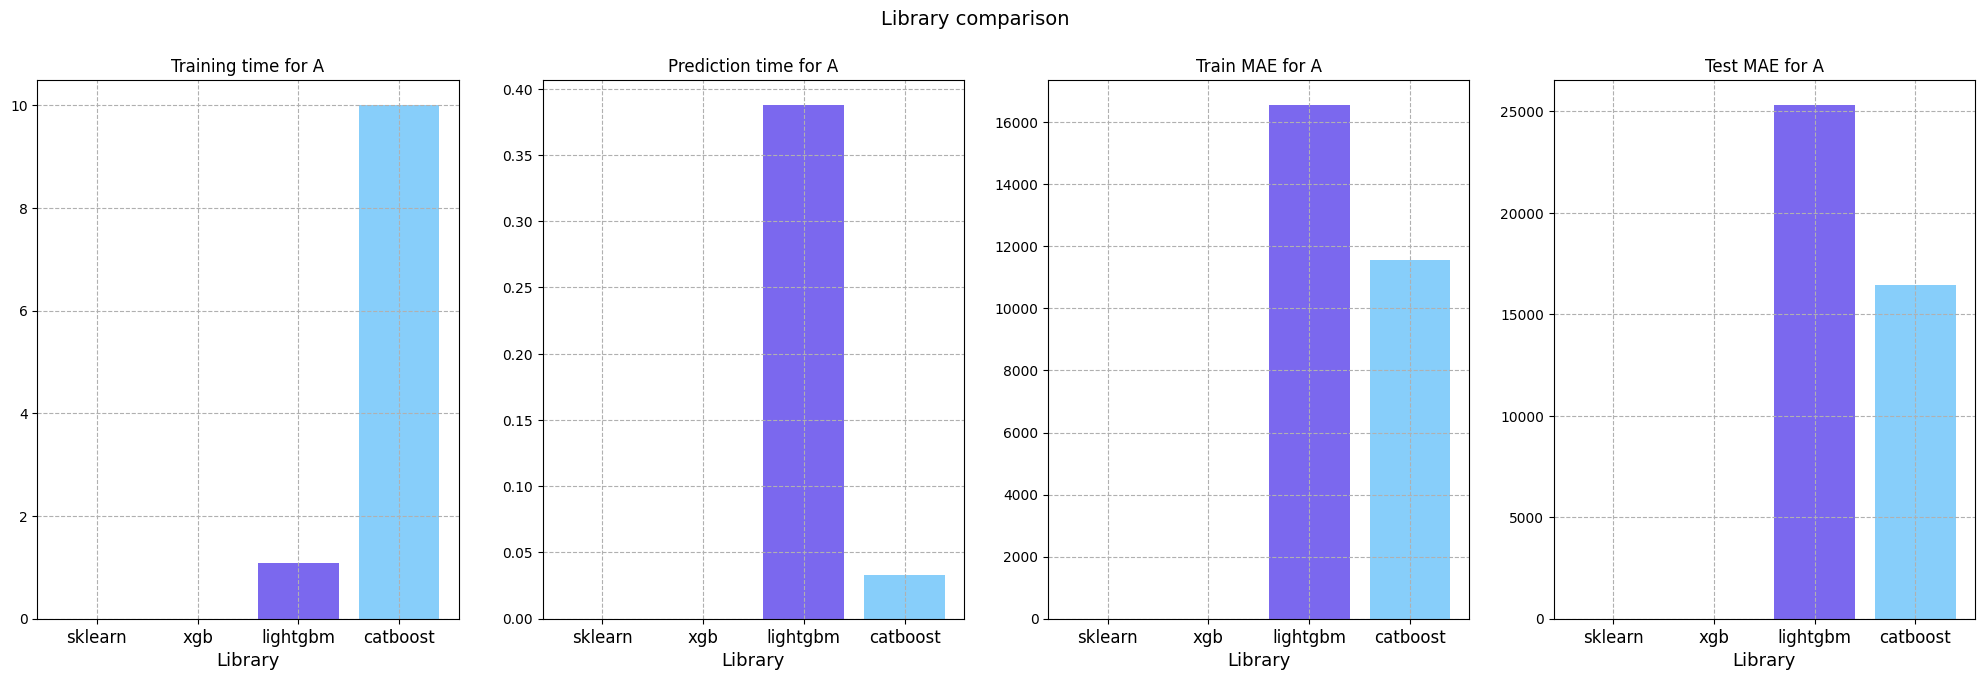

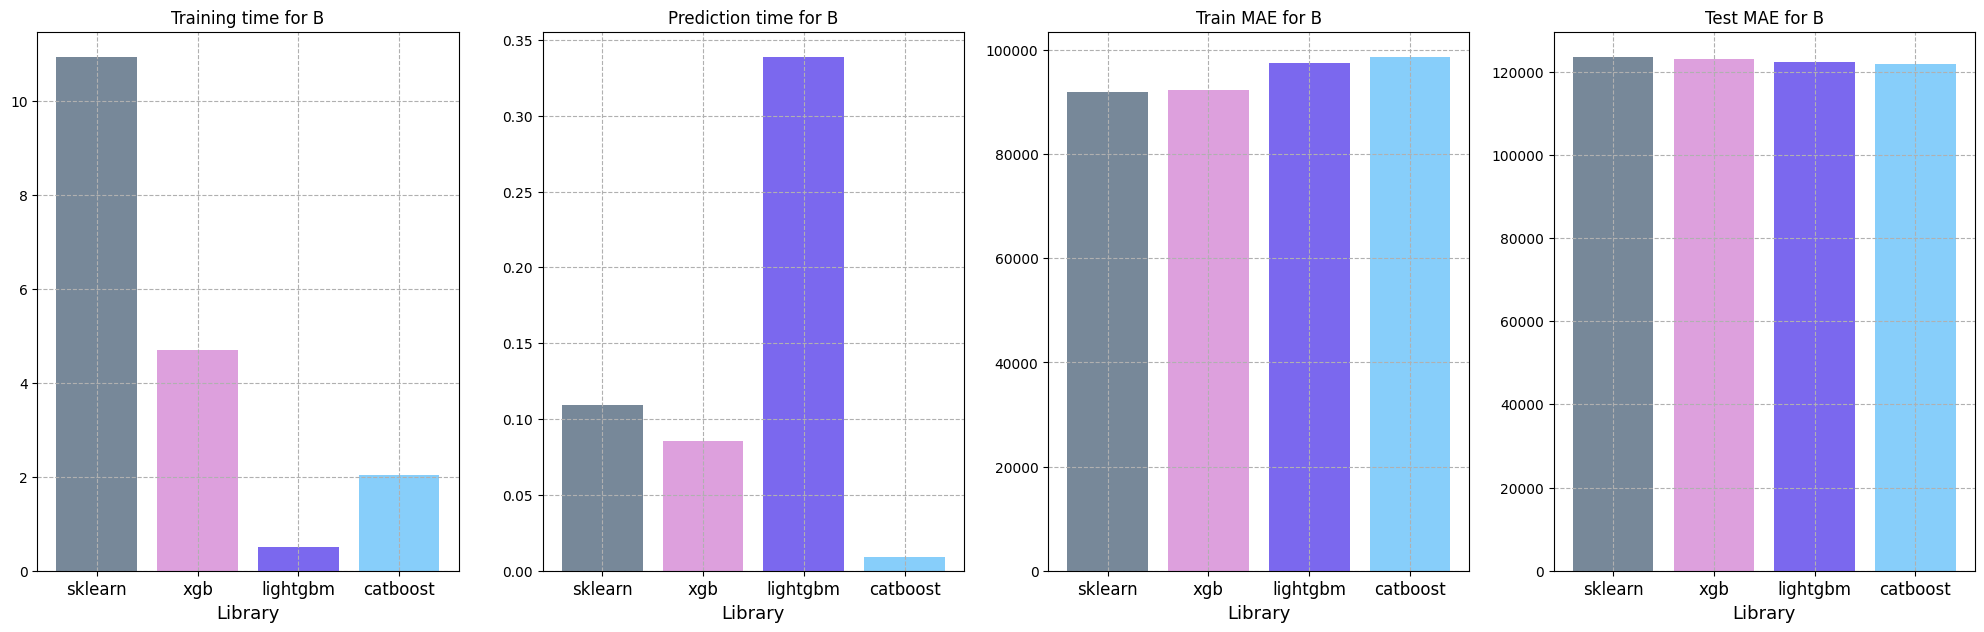

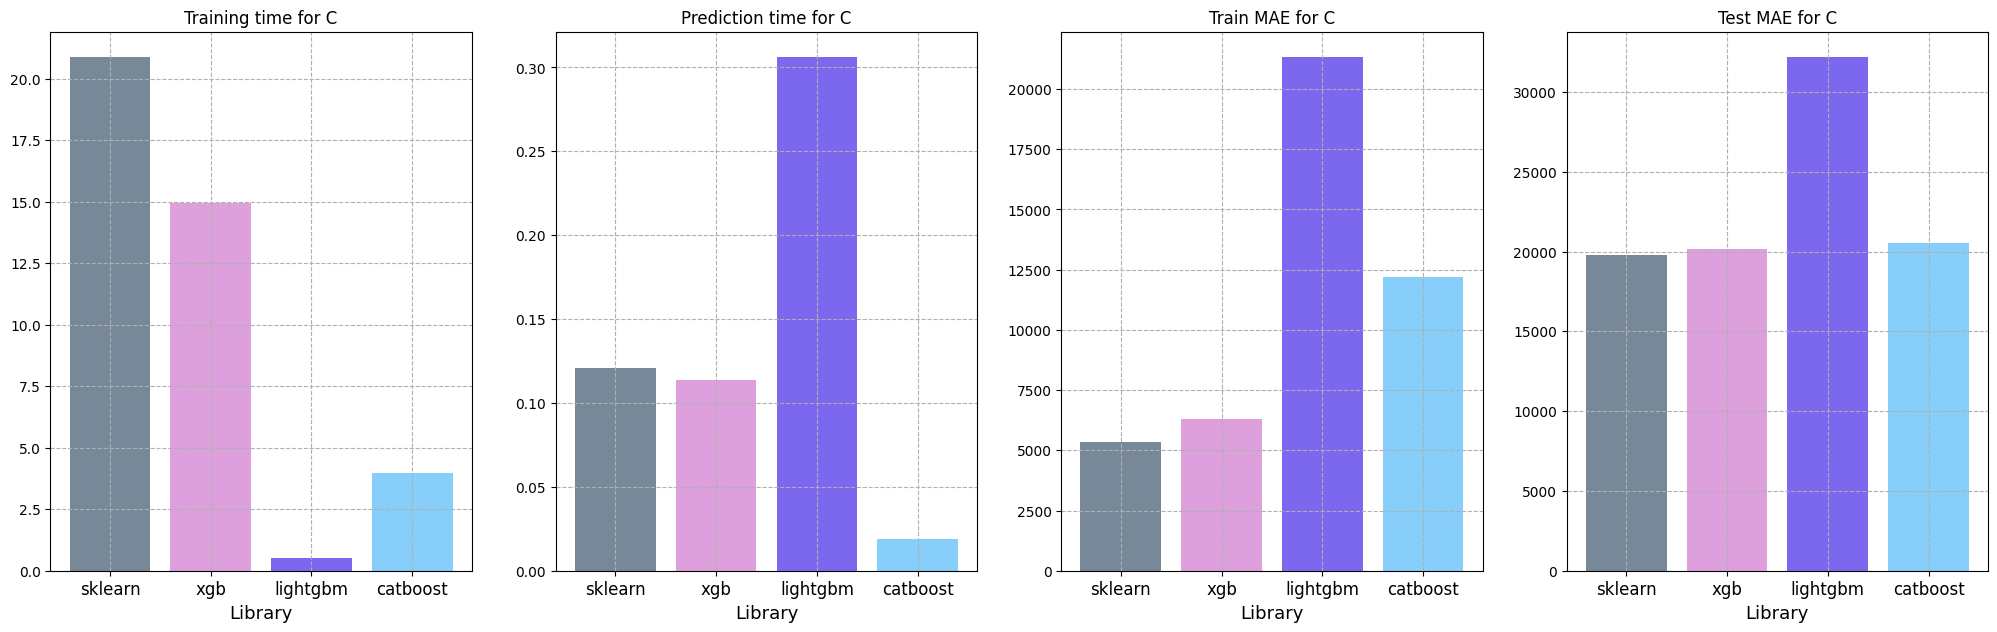

In [ ]:
col_name = ['Training time', 'Prediction time', 'Train MAE', 'Test MAE']

for key in ['A', 'B', 'C']:
  plt.figure(figsize=(25, 7))

  if key is 'A':
    plt.suptitle('Library comparison', fontsize=14)
  for i in range(1, 5):
    plt.subplot(1, 4, i)
    plt.title(col_name[i - 1] + ' for ' + key)

    width = 0.2

    plt.bar(np.arange(4), df_all[df_all['Dataset'] == key][col_name[i - 1]], color=['lightslategrey', 'plum', 'mediumslateblue', 'lightskyblue'])

    plt.xticks(np.arange(4), ['sklearn', 'xgb', 'lightgbm', 'catboost'], fontsize=12)
    plt.xlabel('Library', fontsize=13)

    plt.grid(linestyle='--')


  plt.show()

**<font color='magenta'>Выводы:</font>**  
1.   Время обучения меньше всего у библиотеки lightgbm, при этом время предсказания у нее самое высокое.
2.   Самое низкое время предсказания у библиотеки catboost.
3.   Точность на разных датасетах очень сильно меняется. На трейне самая лучшая точность у sklearn и xgb.
4.   Самая худшая точность у lightgbm, причем как на обучающей, так и на тестовой выборке.
5.   Точность остальных библиотек на тесте примерно одинаковая.




----------------------------------------------
<font color="white" style="opacity:0.2023"></font>

# Оптимизация параметров

И так, мы с вами научились пользоваться библиотеками для градиентного бустинга. Пришло время заняться самой интересной (нет) частью исследований, а именно подбором параметров!

Выберите любые две библиотеки из тех, с которыми мы работали в этом ноутбуке, и осуществите для них перебор параметров по сетке.

Обратите внимание, что:

1. Для всех библиотек вы можете воспользоваться классом `GridSearchCV`, реализованном в `sklearn`, осуществляющим кросс-валидацию всех параметров и поиск модели с лучшим качеством. Этот класс позволяет установить количество разбиений датасета, что достаточно сильно влияет на время работы. Также вы можете воспользоваться `n_jobs = -1` для распараллеливания процесса перебора. <font color='red'>**Внимание!**</font> Если вы устанавливаете n_jobs для GridSearchCV, то не надо использовать этот параметр для обучаемых регрессоров! Результат может быть плачевным в плане времени...
2. В `CatBoost` существует своя реализация перебора параметров, которым также можно воспользоваться (речь о `grid_search`).
3. Для подбора правильной сетки параметров советуем обратиться к краткому руководству в `начале ноутбука.`



### <font color='orange'>**Задание 7.1 (кросс-проверка, 5 баллов)**</font>
**Данные**: датасет со стоимостью подержанных автомобилей  
**Метрика**: MAE  
**Цели**: В данном задании следует выполнить следующие пункты:  
1. Взять `две любые библиотеки градиентного бустинга` (можете взять самые быстрые)
2. Составить `сетку перебора параметров`, включающую не менее трех параметров из n_estimators, max_depth, subsample и learning_rate.
3. Осуществите перебор параметров по вашей сетке при помощи GridSearchCV на `датасетах B и C.` Замерьте `время перебора.` Посчитайте `качество модели `обученной с оптимальными (с позиции кросс-валидации) параметрами на тренировочном и тестовом множествах.
4. `Сделайте выводы` о полезности перебора параметров.

<font color='red'>**Внимание!**</font>

По какой-то причине, которую нам не удалось выяснить, иногда catboost в google colab работает очень медленно при переборе параметров. Если в соответствующем задании время обучения catboost занимает не многим более 10 секунд, то в случае кросс-валидации оно возрастает до 5 минут (соответственно, 5 минут в каждом из узлов). Поэтому используйте catboost на свой страх и риск :)

In [ ]:
df_optimized = pd.DataFrame(columns=['Library', 'Dataset', 'Training time', 'Train MAE', 'Test MAE'])

# your ideal code goes here

param_grid = {
  'n_estimators': [500, 1200, 3000],
  'max_depth': [5, 7, 10],
  'subsample': [0.5, 0.75, 1.0],
  'learning_rate': np.logspace(-2, 0, 3)
}

In [ ]:
ind = 0

for key in ['B', 'C']:
  X_train, X_test, y_train, y_test = datasets[key]['X_train'], datasets[key]['X_test'], datasets[key]['y_train'], datasets[key]['y_test']

  df_optimized.loc[ind, 'Library'] = 'lightgbm'
  df_optimized.loc[ind, 'Dataset'] = key

  grid_search = GridSearchCV(LGBMRegressor(verbose=-1), param_grid, cv=4, scoring='neg_mean_absolute_error', n_jobs=-1)

  start_time = time.time()
  grid_search.fit(X_train, y_train)
  df_optimized.loc[ind, 'Training time'] = time.time() - start_time

  print(f'Best params on dataset {key} with library lightgbm :', grid_search.best_params_)

  best_model = LGBMRegressor(**grid_search.best_params_, verbose=-1)
  best_model.fit(X_train, y_train)

  df_optimized.loc[ind, 'Train MAE'] = mean_absolute_error(y_train, best_model.predict(X_train))
  df_optimized.loc[ind, 'Test MAE'] = mean_absolute_error(y_test, best_model.predict(X_test))

  ind += 1

Best params on dataset B with library lightgbm : {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 500, 'subsample': 0.5}
Best params on dataset C with library lightgbm : {'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 500, 'subsample': 0.5}


In [ ]:
df_optimized

,Library,Dataset,Training time,Train MAE,Test MAE
0,lightgbm,B,376.56721,100237.172344,122082.208738
1,lightgbm,C,424.369509,17246.396812,24531.938397


In [ ]:
ind = 2

for key in ['B', 'C']:
  X_train, X_test, y_train, y_test = datasets[key]['X_train'], datasets[key]['X_test'], datasets[key]['y_train'], datasets[key]['y_test']

  df_optimized.loc[ind, 'Library'] = 'xgb'
  df_optimized.loc[ind, 'Dataset'] = key

  grid_search = GridSearchCV(XGBRegressor(), param_grid, cv=4, scoring='neg_mean_absolute_error', n_jobs=-1)

  start_time = time.time()
  grid_search.fit(X_train, y_train)
  df_optimized.loc[ind, 'Training time'] = time.time() - start_time

  print(f'Best params on dataset {key} with library xgb :', grid_search.best_params_)

  best_model = XGBRegressor(**grid_search.best_params_)
  best_model.fit(X_train, y_train)

  df_optimized.loc[ind, 'Train MAE'] = mean_absolute_error(y_train, best_model.predict(X_train))
  df_optimized.loc[ind, 'Test MAE'] = mean_absolute_error(y_test, best_model.predict(X_test))

  ind += 1

Best params on dataset B with library xgb : {'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 1200, 'subsample': 1.0}
Best params on dataset C with library xgb : {'learning_rate': 0.01, 'max_depth': 10, 'n_estimators': 1200, 'subsample': 0.5}


In [ ]:
df_optimized

,Library,Dataset,Training time,Train MAE,Test MAE
0,lightgbm,B,376.56721,100237.172344,122082.208738
1,lightgbm,C,424.369509,17246.396812,24531.938397
2,xgb,B,1875.259719,106480.929013,121461.77056
3,xgb,C,8628.62077,8243.16904,16410.516522


In [ ]:
df_all[df_all['Library'].isin(['lightgbm', 'xgb']) & df_all['Dataset'].isin(['B', 'C'])]

,Dataset,Training time,Prediction time,Train MAE,Test MAE,Library
0,B,4.16252,0.176395,92415.037286,123037.212284,xgb
1,C,16.933726,0.104032,6286.63374,20161.287814,xgb
1,B,0.469437,0.345329,97470.369334,122340.527995,lightgbm
2,C,0.500769,0.307646,21315.998464,32166.734318,lightgbm


**<font color='magenta'>Выводы:</font>** Перебирать параметры очень полезно, т.к. с помощью перебора мы смогли добиться улучшения качества на тесте.

### <font color='orange'>**[Бонус] Задание 7.2 (кросс-проверка, 4 балла)**</font>
**Данные**: датасет со стоимостью подержанных автомобилей  
**Метрика**: MAE  
**Цели**: В данном задании следует выполнить следующие пункты:  
1. Выполнить задание `7.1 с использованием всех библиотек` (для каждой библиотеки можно использовать свою сетку перебора). Разрешается использовать маленькие сетки с небольшим числом узлов, но не менее 8 (под узлом понимается число пересечений в сетке, а не число параметров; итого, для каждого из 3 параметров достаточно перебрать по 2 значения).
1. Вывести ниже `результаты работы` с нашими дефолтными параметрами, а также с оптимальными.
1. Вы будете получать `1 балл за каждую библиотеку` с использованием которой точность с вашими подобранными параметрами `превзойдет качество` с использованием дефолтных параметров на **тренировочной** и **тестовой** выборках. Таким образом, максимальный балл за задание равен числу библиотек, 4 балла.


In [25]:
df_optimized_new = pd.DataFrame(columns=['Library', 'Dataset', 'Training time', 'Train MAE', 'Test MAE'])

In [36]:
# your genious code here

#lightgbm
param_grid = {
  'n_estimators': [890, 1200],
  'max_depth': [10, 7],
  'subsample': [0.5, 0.75],
  'learning_rate': np.logspace(-2, -1, 2)
}

ind = 0

for key in ['B', 'C']:
  X_train, X_test, y_train, y_test = datasets[key]['X_train'], datasets[key]['X_test'], datasets[key]['y_train'], datasets[key]['y_test']

  df_optimized_new.loc[ind, 'Library'] = 'lightgbm'
  df_optimized_new.loc[ind, 'Dataset'] = key

  grid_search = GridSearchCV(LGBMRegressor(verbose=-1), param_grid, cv=4, scoring='neg_mean_absolute_error', n_jobs=-1)

  start_time = time.time()
  grid_search.fit(X_train, y_train)
  df_optimized_new.loc[ind, 'Training time'] = time.time() - start_time

  print(f'Best params on dataset {key} with library lightgbm :', grid_search.best_params_)

  best_model = LGBMRegressor(**grid_search.best_params_, verbose=-1)
  best_model.fit(X_train, y_train)

  df_optimized_new.loc[ind, 'Train MAE'] = mean_absolute_error(y_train, best_model.predict(X_train))
  df_optimized_new.loc[ind, 'Test MAE'] = mean_absolute_error(y_test, best_model.predict(X_test))

  ind += 1

Best params on dataset B with library lightgbm : {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 890, 'subsample': 0.5}
Best params on dataset C with library lightgbm : {'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 890, 'subsample': 0.5}


In [37]:
df_optimized_new

,Library,Dataset,Training time,Train MAE,Test MAE
0,lightgbm,B,47.132578,95716.147,122975.253891
1,lightgbm,C,58.454535,13520.547093,24456.234766


XGB возьмем из предыдущего задания.

----------------------------------------------
<font color="white" style="opacity:0.2023"></font>

Обычнно перебор параметров и поиск по сетке это самая скучная часть работы, поскольку занимает много времени, но не гарантирует воспроизведение результата при небольшом изменении датасета, да и сетку надо переосмысливать при каждом обновлении.

Но сейчас мы поймём, что этого можно избежать, поскольку есть библиотека, которая всё сделает за нас!

Эмоции выполняющего в этот момент.png

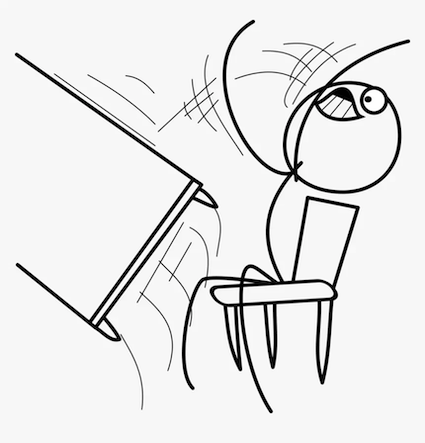

# HyperOpt

Нашего спасителя зовут `HyperOpt.` На первый взгляд hyperopt делает всё то же самое, что и grid search, а именно перебирает параметры. По факту же hyperopt превращает это в задачу оптимизации, используя некоторые эвристики для ускорения сходимости процесса. К тому же, он требует лишь информацию о границе интервалов, а не сами сетки. В теории это должно помочь нам добиться лучших результатов за более короткое время. Давайте попробуем это сделать.

Для данного эксперимента я рекомендую использовать lightgbm, поскольку она быстрее и с ней удобнее играться, но Вы можете воспользоваться любой библиотекой из представленных выше.



### <font color='orange'>**Задание 8 (кросс-проверка, 4 балла)**</font>
**Данные**: датасет со стоимостью подержанных автомобилей

**Метрика**: MAE

**Цели**: В данном задании следует выполнить следующие пункты:
1. Взять `любую библиотеку градиентного бустинга` (можете взять самую быструю)
2. Составить `сетку перебора в hyperopt`, включающую параметры n_estimators, max_depth, subsample и learning_rate в hyperopt. Вам могут понадобиться такие типы данных, как `hp.choice, hp.qloguniform, hp.uniform и hp.quniform`(можно также пользоваться np.arange). Также для округления значения типа float до целых чисел (4.0 -> 4) используйте `scope.int`.
3. `Реализуйте функцию`, которая принимает на вход словарь параметров для регрессора, и при помощи cv оценивает его качество на датасете A (можно воспользоваться cross_val_score, а для ускорения поставить cv=3). Не забудьте о том, в каком виде lightgbm принимает категориальные признаки в numpy и что также надо передавать индексы категориальных признаков.
4. Создайте объект `trials=Trials()`, который будет хранить информацию о процессе оптимизации.
5. Используя функцию fmin, `оптимизируйте Вашу функцию`. Установите algo=tpe.suggest, trials=trials и max_evals, по крайней мере, 50. verbose=1 позволит видеть прогресс-бар по типу tqdm.
6. `Выведите` получившиеся параметры. `Нарисуйте график`, показывающий значение loss в ходе оптимизации. `Посчитайте качество` на тесте при использовании лучших параметров (возвращаются после использования fmin).
7. `Сделайте выводы` по результату.

In [6]:
#your code goes right here
from hyperopt import STATUS_OK

search_space = {
    'n_estimators': scope.int(hp.loguniform('n_estimators', np.log(10), 4 * np.log(10))),
    'max_depth': hp.choice('max_depth', options=np.arange(5, 12)),
    'subsample': hp.uniform('subsample', 0.1, 1.0),
    'learning_rate': hp.loguniform('learning_rate', -5 * np.log(10), 0 * np.log(10))
}

In [7]:
def objective(params):
  model = LGBMRegressor(**params, verbose=-1)
  score = cross_val_score(model, X=datasets['A']['X_train'], y=datasets['A']['y_train'], scoring='neg_mean_absolute_error', cv=3, n_jobs=-1, fit_params={'categorical_feature': 'auto'})

  return {'loss': -score.mean(), 'params': params, 'status': STATUS_OK}

In [16]:
trials = Trials()

best_params = fmin(fn=objective, space=search_space, algo=tpe.suggest, trials=trials, max_evals=50, verbose=1)
print(f'Best parameters are {best_params}')

100%|██████████| 50/50 [05:31<00:00,  6.62s/trial, best loss: 30432.17736137009]
Best parameters are {'learning_rate': 0.016546410048218965, 'max_depth': 6, 'n_estimators': 2543.5100399032235, 'subsample': 0.4180023357720384}


In [18]:
best_params['n_estimators'] = int(best_params['n_estimators'])
best_params['max_depth'] = np.arange(5, 12)[best_params['max_depth']]

best_model = LGBMRegressor(**best_params, verbose=-1)
best_model.fit(datasets['A']['X_train'], datasets['A']['y_train'])

test_mae = mean_absolute_error(datasets['A']['y_test'], best_model.predict(datasets['A']['X_test']))
print(f'Test MAE with best parameters is {test_mae}')

Test MAE with best parameters is 20845.564537620445


In [19]:
base_model = LGBMRegressor(**test_parameters, verbose=-1)
base_model.fit(datasets['A']['X_train'], datasets['A']['y_train'])

test_mae = mean_absolute_error(datasets['A']['y_test'], base_model.predict(datasets['A']['X_test']))
print(f'Test MAE with default (test) parameters is {test_mae}')

Test MAE with default (test) parameters is 25297.219522357504


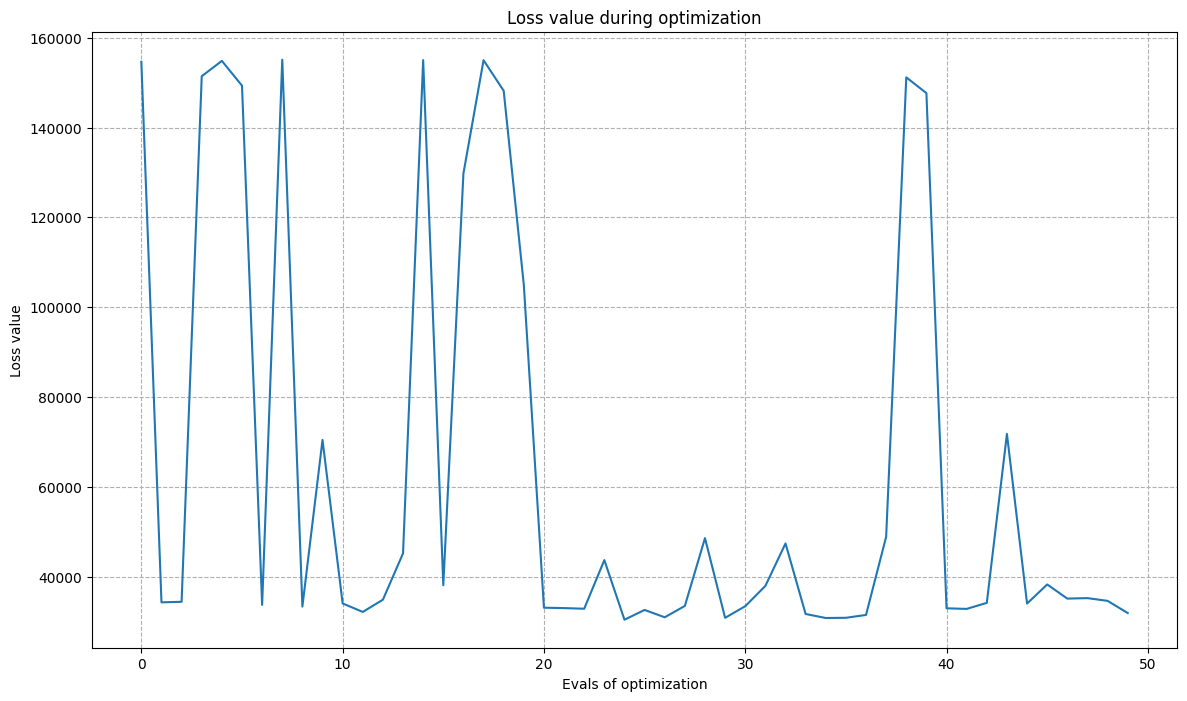

In [20]:
plt.figure(figsize=(14, 8))
plt.title('Loss value during optimization')

plt.plot(trials.losses())

plt.xlabel('Evals of optimization')
plt.ylabel('Loss value')

plt.grid(linestyle='--')

plt.show()

**<font color='magenta'>Выводы:</font>** Подбор параметров оказался намного быстрее чем в GridSearch. Всем советую.

# Предсказание зрительских симпатий

Ну что, детишки, а теперь перейдём к действительно важным вопросам.

**<font color='red'>Внимание!</font>** Следующее задание сдается в системе cv-gml.ru, задание `Град. бустинг (ML)` Для выполнения этого задания необходимо скачать датасет из задания. Здесь вы можете немного почитать про датасет и, при желании, поэкспериментировать. На cv-gml.ru загружайте уже готовый скрипт с подобранными параметрами для обучаемого регрессора. Релизовать код необходимо в шаблонном файле `awards_prediction.py`, который вы можете найти в проверяющей системе.

----------------------------------------------
<font color="white" style="opacity:0.2023"></font>

В некотором царстве, некотором государстве была развита кинопромышленность. Новые фильмы в этом государстве показывают по интернету, а пользователи после просмотра могут дать фильму некоторую "награду". Наша цель - предсказать число наград для фильма.

В нашем распоряжении имеются следующие данные:

**awards** - количество наград, полученных фильмом от пользователей (целевое значение)  
**potions** - количество магических зелий, потраченных на создание спец-эффектов  
**genres** - жанры созданного фильма  
**questions** - количество вопросов, заданных пользователями на соответствующих форумах об этом фильме до премьеры  
**directors** - режиссеры фильма (если неизвестны, то unknown)  
**filming_locations** - области, в которых снимался фильм  
**runtime** - продолжительность фильма в некоторых единицах, принятых в этом государстве  
**critics_liked** - количество критиков из 100, присудивших награды фильму на предварительных закрытых показах  
**pre-orders** - количество зрителей, заранее купивших билеты на первый показ  
**keywords** - ключевые слова, описывающие содержание фильма
**release_year** - год, во котором фильм был показан (конечно, в летоисчислении этого государства)

Следующие поля появляются несколько раз с разными значениями i:

**actor_i_known_movies** - количество известных фильмов актера i (i от 0 до 2)

**actor_i_postogramm** - количество подписчиков в социальной сети "по сто грамм" актера i (i от 0 до 2)

**actor_i_gender** - пол актера i (i от 0 до 2)

**actor_i_age** - возраст актера i (i от 0 до 2)

-----
**<font color='red'>Внимание!</font>** Учтите, что при OHE кодировании признаки на обучении и тестировании должны совпадать! Если вы примените простое .get_dummies() или что-то подобное, то признаки на трейне и тесте получатся разные! Так что вам, вероятно, придётся придумать способ для того, чтобы сохранить их :)  

**<font color='red'>Внимание!</font>** Нельзя исключать вероятность того, что злые силы добавили в наш датасет пропуски, поэтому лучше лишний раз как-нибудь заполнить пропущенные значения.

Подсказка: для работы с текстом можно воспользоваться методом TF-IDF (ключевые слова: TfIdfTransformer). Также может быть полезен CountVectorizer. Только учтите, что никто не гарантирует улучшение результата с использованием данных методов  ;)

**<font color='red'>Внимание!</font>** В проверяющей системе имеется проблема с catboost. При использовании этой библиотеки, в скрипте с решением необходимо инициализировать метод с использованием `train_dir` как показано тут:
`CatBoostRegressor(train_dir='/tmp/catboost_info')`

## **<font color='orange'>Задание 9 (ML задание, 27 баллов)</font>**
**Данные**: датасет с наградами за фильмы

**Метрика**: MAE  

**Цели**: В данном задании следует выполнить следующие пункты:  
1. Взять `любую библиотеку градиентного бустинга`
2. Используя предложенный датасет, `обучить регрессор` для предсказания awards (предоставляем полную свободу в настройках и выборе методов)
3. `Загрузить решение` и получить качество на закрытой выборке больше порогового значения

In [5]:
## your efficient code here

df_train = pd.read_json('train.jsonl', lines=True)
df_test = pd.read_json('test.jsonl', lines=True)

In [6]:
y_train = df_train['awards']
df_train = df_train.drop(['awards'], axis=1)
train_size = df_train.shape[0]

data = pd.concat([df_train, df_test], axis=0)
data = data.drop('keywords', axis=1)

In [7]:
# remove categorical variables
cat_cols = ['genres', 'directors', 'filming_locations']
gender_cols = ['actor_0_gender', 'actor_1_gender', 'actor_2_gender']

for col in cat_cols:
    data[col] = data[col].apply(
        lambda x: ['unknown'] if (isinstance(x, str) and x.lower() == 'unknown') else x
    )
    data[col] = data[col].str.join(',')

for i in range(3):
    data[f"actor_{i}_gender"] = data[f"actor_{i}_gender"].astype('category')

In [8]:
from sklearn.feature_extraction.text import CountVectorizer

transformer = CountVectorizer(token_pattern=r'[A-Za-z ]+')

genres = transformer.fit_transform(data['genres']).toarray()
directors = transformer.fit_transform(data['directors']).toarray()
locations = transformer.fit_transform(data['filming_locations']).toarray()

transformed = pd.concat([pd.DataFrame(genres), pd.DataFrame(directors), pd.DataFrame(locations)], axis=0)

In [9]:
data = data.drop(cat_cols, axis=1)
data = pd.concat([data, transformed], axis=0)

X_train = data.iloc[:train_size]
X_test = data.iloc[train_size:]

In [11]:
from hyperopt import STATUS_OK

search_space = {
    'n_estimators': scope.int(hp.loguniform('n_estimators', np.log(10), 3 * np.log(10))),
    'max_depth': hp.choice('max_depth', options=np.arange(5, 12)),
    'subsample': hp.uniform('subsample', 0.1, 1.0),
    'learning_rate': hp.loguniform('learning_rate', -5 * np.log(10), 0 * np.log(10))
}

In [16]:
def objective(params):
  model = CatBoostRegressor(**params, verbose=False)
  score = cross_val_score(model, X=X_train, y=y_train, scoring='neg_mean_absolute_error', cv=3, n_jobs=-1, fit_params={'cat_features': gender_cols})

  return {'loss': -score.mean(), 'params': params, 'status': STATUS_OK}

In [17]:
trials = Trials()

best_params = fmin(fn=objective, space=search_space, algo=tpe.suggest, trials=trials, max_evals=50, verbose=1)
print(f'Best parameters are {best_params}')

100%|██████████| 50/50 [19:42<00:00, 23.64s/trial, best loss: 2261.146631496968]
Best parameters are {'learning_rate': 0.038122903406351404, 'max_depth': 2, 'n_estimators': 949.5817513169322, 'subsample': 0.21900534847561628}


In [18]:
np.arange(5, 12)[best_params['max_depth']]

7

# <font color='orange'>[Бонус] задание (2 балла)</font>





Найдите мем про градиентный бустинг лучше, чем этот:

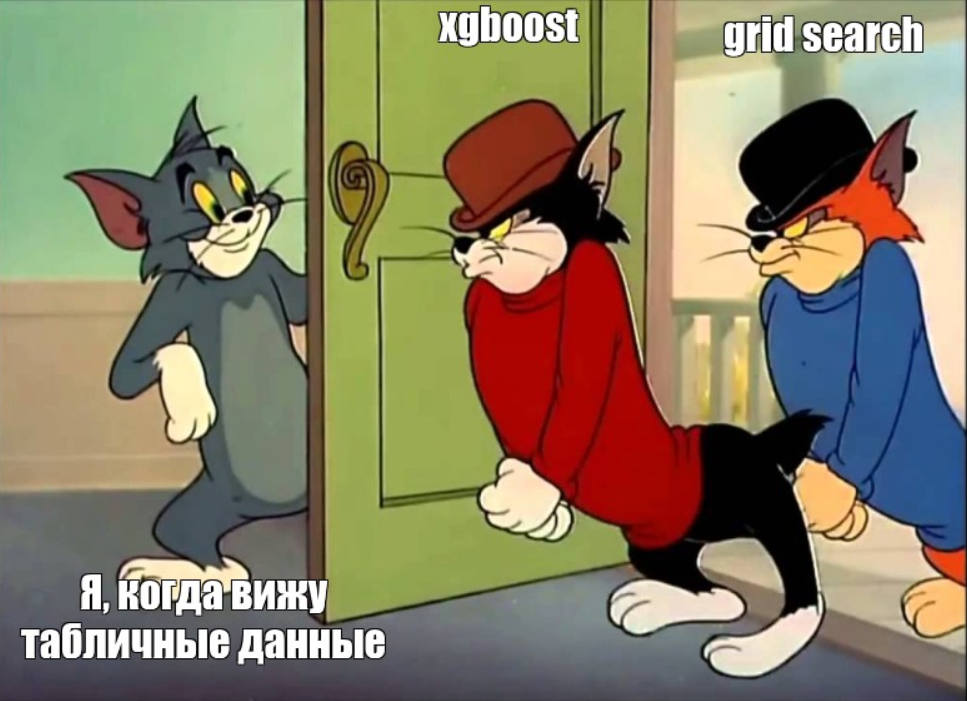


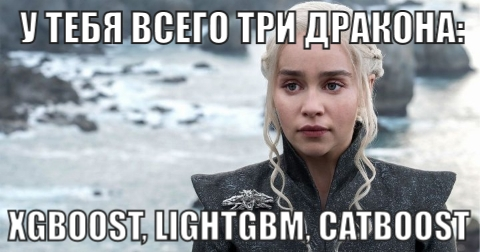


# Конец

Ну что детишки... Можете добавлять еще 4 библиотеки в своё резюме датасаентиста!


```
(╯°□°)╯︵ ┻━┻ FLIP THAT TABLE.

┻━┻ ︵ ヽ(°□°ヽ) FLIP THIS TABLE.

┻━┻ ︵ ＼\('0')/／ ︵ ┻━┻ FLIP ALL THE TABLES

ಠ_ಠ Son... ಠ_ಠ Put. ಠ__ಠ The tables. ಠ___ಠ Back.

(╮°-°)╮┳━┳

(╯°□°)╯︵ ┻━┻ NEVER!!!!
```

